# ONC Mouring at the Mouth of the JDF
lat = 48.508133 <br>
lon = -124.749117<br>
depth = 226 m <br>
station name = OceanNetworksCanada-Pacific-SalishSea-JuandeFucaStrait-JFCNMooring

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.relativedelta import relativedelta
from salishsea_tools import evaltools as et, viz_tools
import cmocean as cmo
import netCDF4 as nc
from matplotlib.colors import LogNorm
from salishsea_tools import geo_tools
import gsw

%matplotlib inline

In [ ]:
def calc_stats(x, y):
    """
    """
    
    stats = {}
    MSE = np.mean((y - x)**2)
    stats['RMSE'] = np.sqrt(MSE)
    stats['bias'] = np.mean(y) - np.mean(x)
    stats['WSS'] = 1 - MSE / np.mean((abs(y - np.mean(x)) + abs(x - np.mean(x)))**2)
    
    return stats


def plot_panel(ax, x, y, lims, units):
    """
    """
    
    stats = calc_stats(x, y)

    statstext = f"RMSE = {stats['RMSE']:.3f} {units}\nbias = {stats['bias']:.3f} {units}\nWSS = {stats['WSS']:.3f}"
    
    props = dict(boxstyle='round', facecolor='w', alpha=0.9)
    ax.text(0.5, 0.04, statstext, bbox=props, transform=ax.transAxes)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    return c

## ONC Mooring with More Data - JF2C
lat = 48.360383 <br>
lon = -124.213367 <br>
depth = 175 m <br>
station name =  OceanNetworksCanada-Pacific-SalishSea-JuandeFucaStrait-JF2CMooring

In [2]:
JF2C = pd.read_csv('JuandeFucaStrait_JF2CMooring_ConductivityTemperatureDepth_20121101T000539Z_20200926T135042Z-NaN_clean.csv', header=113, skiprows=[114])

/home/rbeutel/anaconda3/envs/py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,3,5,7,9,11,13,15,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
JF2C['dtUTC'] = [ pd.to_datetime('{:%Y-%m-%d} {:%H:%M:%S}'.format(pd.to_datetime(ii), pd.to_datetime(ii))) for ii in JF2C['#"Time UTC (yyyy-mm-ddThh:mm:ss.fffZ)"']]

In [4]:
JF2C[' "Practical Salinity (psu)"'] = pd.to_numeric(JF2C[' "Practical Salinity (psu)"'],errors='coerce')
JF2C[' "Temperature (C)"'] = pd.to_numeric(JF2C[' "Temperature (C)"'],errors='coerce')

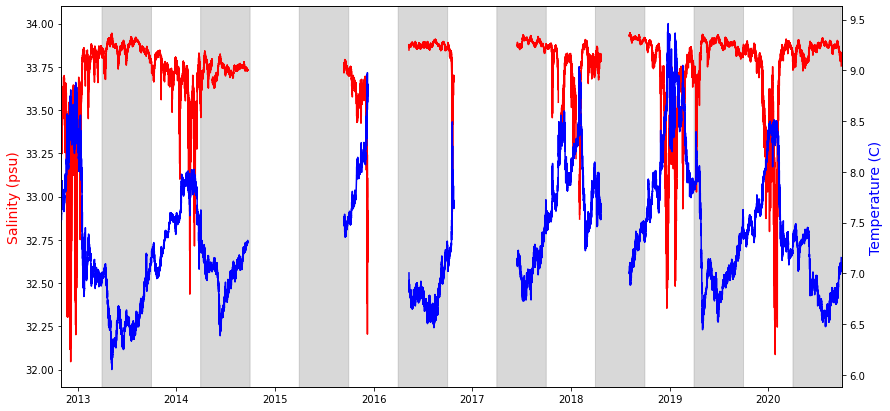

In [5]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(JF2C['dtUTC'],JF2C[' "Practical Salinity (psu)"'], c='r')
ax.set_ylabel("Salinity (psu)",fontsize=14, c='r')
ax.set_ylim(31.9,34.1)
ax.set_xlim(pd.to_datetime('2012-10-31'), pd.to_datetime('2020-09-30'))

ax2 = ax2=ax.twinx()
ax2.plot(JF2C['dtUTC'],JF2C[' "Temperature (C)"'], c='b')
ax2.set_ylabel("Temperature (C)",fontsize=14, c='b')

# #set summer upwelling as apr1-sep30
season = [pd.to_datetime(pd.to_datetime('2013-04-01') + relativedelta(months=6*i)) for i in range(16)]
for i in range(0, len(season),2):
    ax.fill_between(JF2C['dtUTC'], 30, 35, where=(JF2C['dtUTC']<season[i+1])&(JF2C['dtUTC']>=season[i]), color='grey', alpha=0.3)

grey = summer upwelling (april 01 to september 30) <br>
white = winter downwelling (october 01 to march 31)

In [6]:
with nc.Dataset('/ocean/rbeutel/MEOPAR/grid/mesh_mask201702.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])
    e3t_0=np.copy(mesh.variables['e3t_0'][0,:,:,:])
    gdepw=np.copy(mesh.variables['gdepw_0'][0,:,:,:])
    print(mesh.variables.keys())

dict_keys(['nav_lon', 'nav_lat', 'time_counter', 'tmask', 'umask', 'vmask', 'fmask', 'tmaskutil', 'umaskutil', 'vmaskutil', 'fmaskutil', 'glamt', 'glamu', 'glamv', 'glamf', 'gphit', 'gphiu', 'gphiv', 'gphif', 'e1t', 'e1u', 'e1v', 'e1f', 'e2t', 'e2u', 'e2v', 'e2f', 'ff', 'mbathy', 'misf', 'isfdraft', 'e3t_0', 'e3u_0', 'e3v_0', 'e3w_0', 'gdept_0', 'gdepu', 'gdepv', 'gdepw_0', 'gdept_1d', 'gdepw_1d', 'e3t_1d', 'e3w_1d'])


In [7]:
obslon=-124.213367
obslat=48.360383
j,i=geo_tools.find_closest_model_point(-124.213367,obslat,navlon,navlat)

In [8]:
JF2C['i'] = i
JF2C['j'] = j

In [115]:
# [(x,y) for (x,y) in enumerate(gdepw[:,j,i])]

In [10]:
JF2C['k'] = 29

In [11]:
JF2C.head()

,"#""Time UTC (yyyy-mm-ddThh:mm:ss.fffZ)""","""Conductivity (S/m)""","""Conductivity QC Flag""","""Density (kg/m3)""","""Density QC Flag""","""Practical Salinity (psu)""","""Practical Salinity QC Flag""","""Pressure (decibar)""","""Pressure QC Flag""","""Sigma-t (kg/m3)""",...,"""Temperature (C)""","""Temperature QC Flag""","""Corrected Heading (deg)""","""Corrected Heading QC Flag""","""True Heading (deg)""","""True Heading QC Flag""",dtUTC,i,j,k
0,2012-11-01T00:05:39.984Z,3.46341,1,1027.129501642,1,33.6966,1,176.633,1,26.321169007,...,7.5095,1,15.519424824,8,NaN,9,2012-11-01 00:05:39,67,349,29
1,2012-11-01T00:20:40.013Z,3.46334,1,1027.125318521,1,33.6926,1,176.51,1,26.317555192,...,7.5128,1,35.271224379,8,NaN,9,2012-11-01 00:20:40,67,349,29
2,2012-11-01T00:35:40.042Z,3.4634,1,1027.125678565,1,33.6937,1,176.387,1,26.318476948,...,7.5124,1,63.378258601,8,NaN,9,2012-11-01 00:35:40,67,349,29
3,2012-11-01T00:50:39.984Z,3.4634,1,1027.121965548,1,33.6904,1,176.253,1,26.31538511,...,7.5159,1,80.870448824,8,NaN,9,2012-11-01 00:50:39,67,349,29
4,2012-11-01T01:05:40.013Z,3.46351,1,1027.122799241,1,33.6922,1,176.107,1,26.316885697,...,7.5153,1,95.926483824,8,NaN,9,2012-11-01 01:05:40,67,349,29


In [14]:
# path to model files:
PATH= '/results2/SalishSea/nowcast-green.201905/' #path to the results file

# start and end dates for analysis: #will cut off anything before and after
start_date = dt.datetime(2013,1,1)
end_date = dt.datetime(2020,9,26)

# number of days per model file:
flen=1 #the number of days per model output file (almost always 1 for susan, elise does 10)

# dictionary mapping desired model variables to the file types where they are found
filemap={'vosaline':'grid_T','votemper':'grid_T'} 

# dictionary mapping model file types to their time resolution in hours (1 is hourly files, 24 is daily)
fdict={'ptrc_T':1,'grid_T':1} #loading data from hourly files, 1 for 1 hour (daily replace with a 24)

# results format (naming convention and storage format of the files)
# -- nowcast: files like 01jan15/SalishSea_1h_20150101_20150101_ptrc_T.nc
# -- long: files like SalishSea_1h_20150206_20150804_ptrc_T_20150427-20150506.nc, all in one directory
namfmt='nowcast'

In [15]:
# match model output to observations and return both in a dataframe
# the model variables will have their original names prefixed by mod_, eg mod_vosaline
# the observation file names are unchanged. 
data=et.matchData(data=JF2C,filemap=filemap, fdict=fdict, mod_start=start_date, mod_end=end_date, 
                  mod_nam_fmt=namfmt, mod_basedir=PATH, mod_flen=flen, preIndexed=True)
# 

progress: 0.0%
progress: 2.0563522778214183%
progress: 4.1127045556428365%
progress: 6.169056833464254%
progress: 8.225409111285673%
progress: 10.281761389107091%
progress: 12.338113666928509%
progress: 14.394465944749927%
progress: 16.450818222571346%
progress: 18.507170500392764%
progress: 20.563522778214182%
progress: 22.6198750560356%
progress: 24.676227333857017%
progress: 26.732579611678435%
progress: 28.788931889499853%
progress: 30.845284167321275%
progress: 32.90163644514269%
progress: 34.9579887229641%
progress: 37.01434100078553%
progress: 39.070693278606946%
progress: 41.127045556428364%
progress: 43.18339783424978%
progress: 45.2397501120712%
progress: 47.29610238989262%
progress: 49.352454667714035%
progress: 51.40880694553546%
progress: 53.46515922335687%
progress: 55.52151150117829%
progress: 61.69056833464255%
progress: 63.74692061246397%
progress: 65.80327289028538%
progress: 67.8596251681068%
progress: 69.9159774459282%
progress: 71.97232972374964%
progress: 74.02868

In [20]:
# convert observed from psu to g/kg
data['lat'] = 48.360383
data['lon'] =  -124.213367
data["Sea Pressure (db)"] = pd.to_numeric(JF2C[' "Pressure (decibar)"'],errors='coerce')-10.1325

data['Real Salinity (g/kg)'] = gsw.conversions.SA_from_SP(np.array(data[' "Practical Salinity (psu)"']), np.array(data["Sea Pressure (db)"]),np.array(data['lon']),np.array(data['lat']))

In [21]:
# convert modelled from CT to in-situ T
data['modelled T (C)'] = gsw.conversions.t_from_CT(np.array(data['mod_vosaline']), np.array(data['mod_votemper']), np.array(data["Sea Pressure (db)"]))

### mod vs. obs plots

Text(0.5, 1.0, 'Temperature ($^{\\circ}$C)')

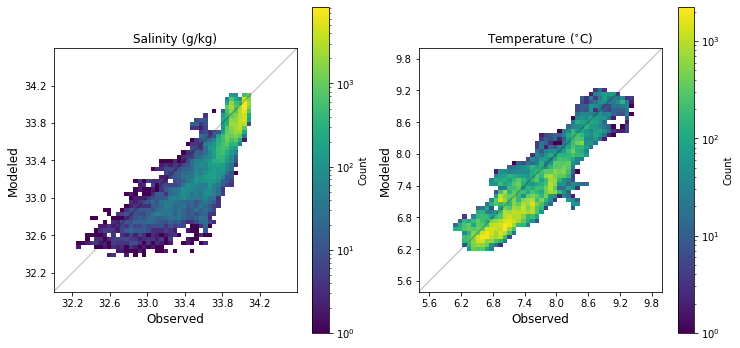

In [22]:
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

axs[0].plot((32,34.6),(32,34.6),'k-',alpha=.2)
axs[1].plot((5.4,10),(5.4,10),'k-',alpha=.2)

iiT=(~np.isnan(data[' "Temperature (C)"']))&(~np.isnan(data['modelled T (C)']))
iiS=(~np.isnan(data['Real Salinity (g/kg)']))&(~np.isnan(data['mod_vosaline']))
counts, xedges, yedges, m1=axs[1].hist2d(data.loc[iiT,[' "Temperature (C)"']].values.flatten(),
                                      data.loc[iiT,['modelled T (C)']].values.flatten(),bins=40,norm=LogNorm())
counts, xedges, yedges, m2=axs[0].hist2d(data.loc[iiS,['Real Salinity (g/kg)']].values.flatten(),
                                      data.loc[iiS,['mod_vosaline']].values.flatten(),bins=40,norm=LogNorm())

cb0=fig.colorbar(m2,ax=axs[0])
cb0.set_label('Count')
cb1=fig.colorbar(m1,ax=axs[1])
cb1.set_label('Count')

ntick=np.arange(32.2, 34.4, 0.4)
axs[0].set_xlim((32,34.6))
axs[0].set_ylim((32,34.6))
axs[0].set_xticks(ntick)
axs[0].set_yticks(ntick)
    
stick=np.arange(5.6,9.8, 0.6)
axs[1].set_xlim((5.4,10))
axs[1].set_ylim((5.4,10))
axs[1].set_xticks(stick)
axs[1].set_yticks(stick)
    
for ax in (axs[1],axs[0]):
    ax.set_aspect(1, adjustable='box')
    
axs[1].set_ylabel('Modeled',fontsize=12)
axs[0].set_ylabel('Modeled',fontsize=12)
axs[1].set_xlabel('Observed',fontsize=12)
axs[0].set_xlabel('Observed',fontsize=12)

axs[0].set_title('Salinity (g/kg)',fontsize=12)
axs[1].set_title('Temperature ($^{\circ}$C)',fontsize=12)

# plot the stats pannel
c = plot_panel(axs[0], data['Real Salinity (g/kg)'], data['mod_vosaline'], (32,34.6), 'g/kg')
c = plot_panel(axs[1], data[' "Temperature (C)"'], data['modelled T (C)'], (5.4,10), '$^{\circ}$C')

^ looks like there's a lsight tendency in the model to nunderestimate the salinity and temperature

# do same comparison to CIOPS-BC12?

In [23]:
# the question is - does the function above only work for SSC files? - they don't
# use the same process, try to make similar functions for CIOPS

In [6]:
with nc.Dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])
    e3t_0=np.copy(mesh.variables['e3t_0'][0,:,:,:])
    gdepw=np.copy(mesh.variables['gdepw_0'][0,:,:,:])
    print(mesh.variables.keys())

dict_keys(['nav_lon', 'nav_lat', 'nav_lev', 'time_counter', 'tmask', 'umask', 'vmask', 'fmask', 'tmaskutil', 'umaskutil', 'vmaskutil', 'fmaskutil', 'glamt', 'glamu', 'glamv', 'glamf', 'gphit', 'gphiu', 'gphiv', 'gphif', 'e1t', 'e1u', 'e1v', 'e1f', 'e2t', 'e2u', 'e2v', 'e2f', 'ff', 'mbathy', 'misf', 'isfdraft', 'e3t_0', 'e3u_0', 'e3v_0', 'e3w_0', 'gdept_0', 'gdepu', 'gdepv', 'gdepw_0', 'gdept_1d', 'gdepw_1d', 'e3t_1d', 'e3w_1d'])


In [7]:
obslon=-124.213367
obslat=48.360383
j,i = np.unravel_index(np.argmin([np.abs(navlon - obslon)+np.abs(navlat - obslat)], axis=None), navlon.shape)

In [8]:
JF2C['i'] = i
JF2C['j'] = j

In [9]:
# [(x,y) for (x,y) in enumerate(gdepw[:,j,i])]

In [40]:
k=29
JF2C['k'] = k

In [61]:
# add column for "real" salinity instead of practical
# convert observed from psu to g/kg
JF2C['lat'] = 48.360383
JF2C['lon'] =  -124.213367
JF2C["Sea Pressure (db)"] = pd.to_numeric(JF2C[' "Pressure (decibar)"'],errors='coerce')-10.1325

JF2C['Real Salinity (g/kg)'] = gsw.conversions.SA_from_SP(np.array(JF2C[' "Practical Salinity (psu)"']), np.array(JF2C["Sea Pressure (db)"]),np.array(JF2C['lon']),np.array(JF2C['lat']))

In [63]:
# do we take the daily average of the mooring since we only have the daily average at that location for CIOPS?
# - makes sense to me!
df = JF2C[JF2C.dtUTC>=dt.datetime(2015,11,22)][JF2C.dtUTC<dt.datetime(2019,12,29)].resample('D',on='dtUTC').mean()#.loc[JF2C.dtUTC].fillna(method='ffill')
df

/tmp/ipykernel_5451/4185689342.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = JF2C[JF2C.dtUTC>=dt.datetime(2015,11,22)][JF2C.dtUTC<dt.datetime(2019,12,29)].resample('D',on='dtUTC').mean()#.loc[JF2C.dtUTC].fillna(method='ffill')


,"""Conductivity QC Flag""","""Density QC Flag""","""Practical Salinity (psu)""","""Practical Salinity QC Flag""","""Pressure QC Flag""","""Sigma-t QC Flag""","""Sigma-theta (0 dbar) QC Flag""","""Sound Speed QC Flag""","""Temperature (C)""","""Temperature QC Flag""","""Corrected Heading QC Flag""","""True Heading QC Flag""",i,j,k,lat,lon,Sea Pressure (db),Real Salinity (g/kg)
dtUTC,,,,,,,,,,,,,,,,,,,
2015-11-22,1.0,1.0,33.601492,1.0,1.0,1.0,1.0,1.0,8.141824,1.0,9.0,8.0,646.0,264.0,29.0,48.360383,-124.213367,174.327281,33.765807
2015-11-23,1.0,1.0,33.606834,1.0,1.0,1.0,1.0,1.0,8.135051,1.0,9.0,8.0,646.0,264.0,29.0,48.360383,-124.213367,174.354646,33.771176
2015-11-24,1.0,1.0,33.615632,1.0,1.0,1.0,1.0,1.0,8.162568,1.0,9.0,8.0,646.0,264.0,29.0,48.360383,-124.213367,174.377365,33.780017
2015-11-25,1.0,1.0,33.621229,1.0,1.0,1.0,1.0,1.0,8.212373,1.0,9.0,8.0,646.0,264.0,29.0,48.360383,-124.213367,174.379875,33.785642
2015-11-26,1.0,1.0,33.635655,1.0,1.0,1.0,1.0,1.0,8.228651,1.0,9.0,8.0,646.0,264.0,29.0,48.360383,-124.213367,174.403656,33.800139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.0,0.0,33.277073,0.0,0.0,0.0,0.0,0.0,8.097140,0.0,9.0,8.0,646.0,264.0,29.0,48.360383,-124.213367,176.629417,33.439853
2019-12-25,0.0,0.0,33.319383,0.0,0.0,0.0,0.0,0.0,8.108135,0.0,9.0,8.0,646.0,264.0,29.0,48.360383,-124.213367,176.620333,33.482371
2019-12-26,0.0,0.0,33.283931,0.0,0.0,0.0,0.0,0.0,8.138458,0.0,9.0,8.0,646.0,264.0,29.0,48.360383,-124.213367,176.598458,33.446745


In [34]:
dates= pd.date_range(dt.datetime(2015,11,22), periods=1498)

In [33]:
fold = [dt.datetime(2015,11,22)+dt.timedelta(days=7*(i+1)) for i in range(int(214))]
fold = np.repeat(fold,7)

In [45]:
potT = [float(xr.open_dataset("/ocean/mdunphy/CIOPSW-BC12/{:%Y%m%d}00/BC12_1d_grid_T_{:%Y%m%d}_{:%Y%m%d}.nc".format(fold[d], dates[d], dates[d]))['thetao'][0,k,j,i].values) for d in range(len(dates))]

In [46]:
S = [float(xr.open_dataset("/ocean/mdunphy/CIOPSW-BC12/{:%Y%m%d}00/BC12_1d_grid_T_{:%Y%m%d}_{:%Y%m%d}.nc".format(fold[d], dates[d], dates[d]))['so'][0,k,j,i].values) for d in range(len(dates))]

In [58]:
P = np.zeros(len(S)).fill(gdepw[k][0][0])

In [59]:
# convert modelled from potential T to in-situ T
CT = gsw.conversions.CT_from_pt(S,potT)
T = gsw.conversions.t_from_CT(S, CT, P)

In [89]:
# make a pandas datafram with your new fun info
d = {'T': T, 'S': S, 'P': P}
ciops = pd.DataFrame(data=d, index=dates)

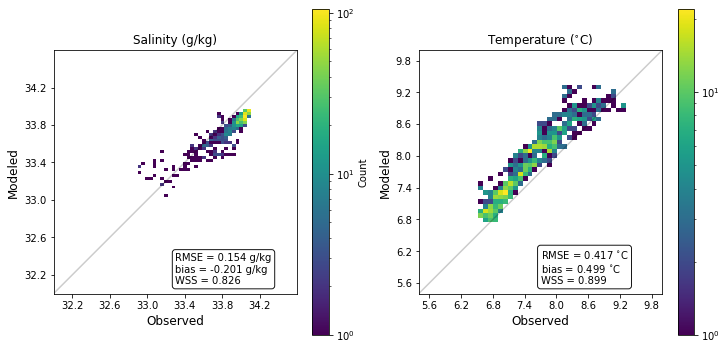

In [114]:
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

axs[0].plot((32,34.6),(32,34.6),'k-',alpha=.2)
axs[1].plot((5.4,10),(5.4,10),'k-',alpha=.2)

iiT=(~np.isnan(df[' "Temperature (C)"']))&(~np.isnan(ciops['T']))
iiS=(~np.isnan(df['Real Salinity (g/kg)']))&(~np.isnan(ciops['S']))
counts, xedges, yedges, m1=axs[1].hist2d(df.loc[iiT,[' "Temperature (C)"']].values.flatten(),
                                      ciops.loc[iiT,['T']].values.flatten(),bins=30,norm=LogNorm())
counts, xedges, yedges, m2=axs[0].hist2d(df.loc[iiS,['Real Salinity (g/kg)']].values.flatten(),
                                      ciops.loc[iiS,['S']].values.flatten(),bins=30,norm=LogNorm())

cb0=fig.colorbar(m2,ax=axs[0])
cb0.set_label('Count')
cb1=fig.colorbar(m1,ax=axs[1])
# cb1.set_label('Count')

ntick=np.arange(32.2, 34.4, 0.4)
axs[0].set_xlim((32,34.6))
axs[0].set_ylim((32,34.6))
axs[0].set_xticks(ntick)
axs[0].set_yticks(ntick)
    
stick=np.arange(5.6,9.8, 0.6)
axs[1].set_xlim((5.4,10))
axs[1].set_ylim((5.4,10))
axs[1].set_xticks(stick)
axs[1].set_yticks(stick)
    
for ax in (axs[1],axs[0]):
    ax.set_aspect(1, adjustable='box')
    
axs[1].set_ylabel('Modeled',fontsize=12)
axs[0].set_ylabel('Modeled',fontsize=12)
axs[1].set_xlabel('Observed',fontsize=12)
axs[0].set_xlabel('Observed',fontsize=12)

axs[0].set_title('Salinity (g/kg)',fontsize=12)
axs[1].set_title('Temperature ($^{\circ}$C)',fontsize=12)

# plot the stats pannel
c = plot_panel(axs[0], df['Real Salinity (g/kg)'], ciops['S'], (32,34.6), 'g/kg')
c = plot_panel(axs[1], df[' "Temperature (C)"'], ciops['T'], (5.4,10), '$^{\circ}$C')